# 02 PyTorch Neural Network Classification

Two types:
1. Binary Classification
2. Multi-Class Classification

## 1. Data

Using make_circles toy dataset from sklearn library

In [1]:
import sklearn
import numpy as np
from sklearn.datasets import make_circles

In [2]:
n_samples = 1000

X, y = make_circles(n_samples,
                    noise=0.03, 
                    random_state=0)

In [3]:
len(X), len(y)

(1000, 1000)

In [4]:
print(f"First 5 samples of X: \n {X[:5]}")
print(f"First 5 samples of y: \n {y[:5]}")

First 5 samples of X: 
 [[ 0.80993549 -0.053514  ]
 [-0.13448628 -0.74209474]
 [-0.81250606 -0.62424399]
 [ 0.5830736   0.49656776]
 [-0.46132008  0.65983601]]
First 5 samples of y: 
 [1 1 0 1 1]


In [5]:
import pandas as pd
circles = pd.DataFrame({"X1": X[:, 0], "X2": X[:, 1], "label": y})
circles.head()

,X1,X2,label
0,0.809935,-0.053514,1
1,-0.134486,-0.742095,1
2,-0.812506,-0.624244,0
3,0.583074,0.496568,1
4,-0.461320,0.659836,1


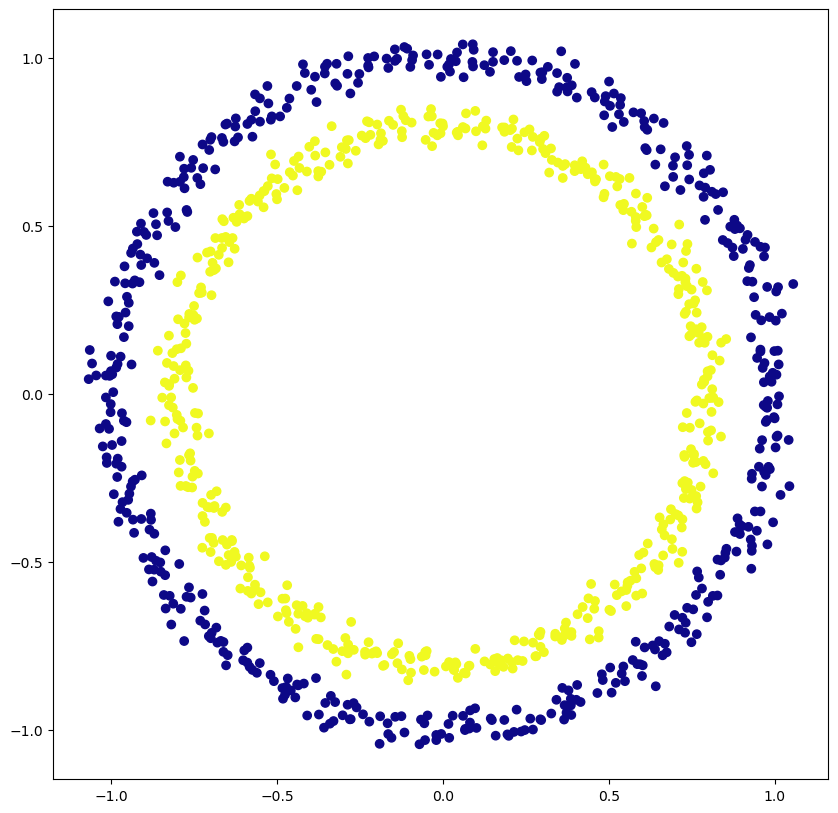

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
plt.scatter(x=X[:, 0], y=X[:, 1], c=y, cmap="plasma");

In [7]:
X.shape, y.shape

((1000, 2), (1000,))

In [8]:
X[0], y[0]

(array([ 0.80993549, -0.053514  ]), 1)

In [9]:
X[0].shape, y[0].shape

((2,), ())

In [10]:
import torch
torch.__version__

'2.0.1'

In [11]:
torch.has_mps

True

In [12]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X[:5], y[:5]

(tensor([[ 0.8099, -0.0535],
         [-0.1345, -0.7421],
         [-0.8125, -0.6242],
         [ 0.5831,  0.4966],
         [-0.4613,  0.6598]]),
 tensor([1., 1., 0., 1., 1.]))

In [13]:
X.dtype, y.dtype

(torch.float32, torch.float32)

In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [15]:
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

## 2. Build Model

1. Setup device-agnostic code, so code runs on the GPU
2. Contruct a model by subclassing `nn.Module`
3. Define a loss function and optimizer
4. Create training and test loop

In [16]:
from torch import nn

device = "mps" if torch.backends.mps.is_available() else "cpu"

In [17]:
X_train.shape, y_train.shape

(torch.Size([800, 2]), torch.Size([800]))

In [18]:
class CircleModelV1 (nn.Module):
    def __init__(self):
        super().__init__()
        
        self.layer1 = nn.Linear(in_features=2, out_features=5) # takes in 2 features from data then upscales it to 5 features, so that it can learn more i.e. hidden features
        self.layer2 = nn.Linear(in_features=5, out_features=1) # the in_features has to be the same number as the previous layer's out_features
        
    def forward(self, x):
        return self.layer2(self.layer1(x))

In [19]:
torch.manual_seed(42)
model_0 = CircleModelV1().to(device)
model_0

CircleModelV1(
  (layer1): Linear(in_features=2, out_features=5, bias=True)
  (layer2): Linear(in_features=5, out_features=1, bias=True)
)

In [20]:
device

'mps'

In [21]:
next(model_0.parameters()).device

device(type='mps', index=0)

In [22]:
# Model replecation using nn.Sequential
torch.manual_seed(42)
torch.mps.manual_seed(42)

model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [23]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[ 0.5406,  0.5869],
                      [-0.1657,  0.6496],
                      [-0.1549,  0.1427],
                      [-0.3443,  0.4153],
                      [ 0.6233, -0.5188]], device='mps:0')),
             ('0.bias',
              tensor([0.6146, 0.1323, 0.5224, 0.0958, 0.3410], device='mps:0')),
             ('1.weight',
              tensor([[-0.0631,  0.3448,  0.0661, -0.2088,  0.1140]], device='mps:0')),
             ('1.bias', tensor([-0.2060], device='mps:0'))])

In [24]:
with torch.inference_mode():
    untrained_preds = model_0(X_test.to(device))
untrained_preds.shape, len(untrained_preds)

(torch.Size([200, 1]), 200)

In [25]:
untrained_preds[:10]

tensor([[-0.1558],
        [-0.0956],
        [-0.1097],
        [-0.2039],
        [-0.1192],
        [-0.1993],
        [-0.0836],
        [-0.2102],
        [-0.1995],
        [-0.1316]], device='mps:0')

In [26]:
torch.round(untrained_preds[:10])

tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]], device='mps:0')

For classification, the loss function would most likely be either binary cross entropy or categorical cross entropy and for optimizer the two most common are SGD and Adam

In [27]:
loss_fn = nn.BCEWithLogitsLoss() # built in sigmoid activation function and is numerically more stable than doing it from scratch
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)

In [28]:
def get_accuracy(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct/len(y_pred)) * 100
    return acc

## 3. Train Model

1. Forward pass
2. Calculate the loss
3. Optimizer zero grad
4. Loss Backward
5. Optimizer step

Our model outputs are going to be in raw **logits** so we need to convert them into something useful: 

raw logits -> prediction probabilities -> prediction labels

We can convert these logits into prediction probabilities by using some kind of activation function like sigmoid, binary cross entropy etc.

Then convert them into prediction labels by rounding them or taking `argmax()`

In [29]:
torch.manual_seed(42)
torch.mps.manual_seed(42)
epochs = 100

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    
    model_0.train()
    
    y_logits = model_0(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))
    
    loss = loss_fn(y_logits, y_train)
    acc = get_accuracy(y_true=y_train, y_pred=y_pred)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    model_0.eval()
    with torch.inference_mode():
        
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        
        test_loss = loss_fn(test_logits, y_test)
        
        test_acc = get_accuracy(y_true=y_test, y_pred=test_pred)
        
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:5f} | Acc: {acc:2f}% | Test Loss: {test_loss:5f} | Test Acc: {test_acc:2f}%")

Epoch: 0 | Loss: 0.694645 | Acc: 51.000000% | Test Loss: 0.701169 | Test Acc: 46.000000%
Epoch: 10 | Loss: 0.693854 | Acc: 51.000000% | Test Loss: 0.698594 | Test Acc: 46.000000%
Epoch: 20 | Loss: 0.693531 | Acc: 51.000000% | Test Loss: 0.697198 | Test Acc: 46.000000%
Epoch: 30 | Loss: 0.693380 | Acc: 50.875000% | Test Loss: 0.696404 | Test Acc: 46.000000%
Epoch: 40 | Loss: 0.693294 | Acc: 48.750000% | Test Loss: 0.695937 | Test Acc: 42.000000%
Epoch: 50 | Loss: 0.693235 | Acc: 46.750000% | Test Loss: 0.695652 | Test Acc: 41.500000%
Epoch: 60 | Loss: 0.693190 | Acc: 48.750000% | Test Loss: 0.695473 | Test Acc: 42.000000%
Epoch: 70 | Loss: 0.693154 | Acc: 50.625000% | Test Loss: 0.695357 | Test Acc: 45.000000%
Epoch: 80 | Loss: 0.693123 | Acc: 51.000000% | Test Loss: 0.695279 | Test Acc: 46.000000%
Epoch: 90 | Loss: 0.693097 | Acc: 51.000000% | Test Loss: 0.695225 | Test Acc: 46.000000%


## 4. Make Predictions and Evaluate Model

In [100]:
def plot_decision_boundary(model, X, y):
    
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))  # binary

    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap="RdBu", alpha=0.5)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=10, cmap="RdBu")
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

In [31]:
def plot_predictions(train_data, train_labels, test_data, test_labels, predictions=None):
    
    plt.figure(figsize=(10, 7))

    plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")
    plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

    if predictions is not None:
        plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

    plt.legend(prop={"size": 14})

[0. 1.]
[0. 1.]


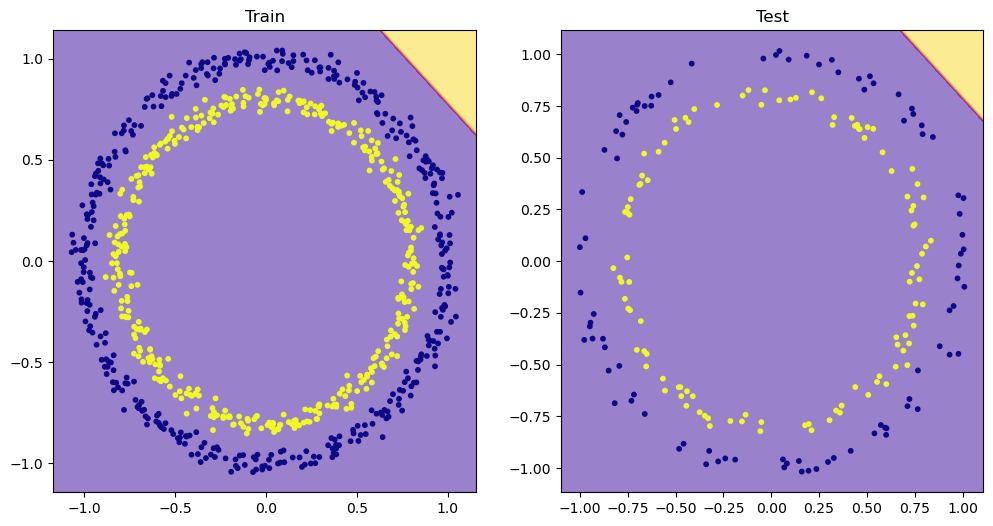

In [32]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)
plt.show()

## 5. Improving a Model

* Add more layers
* Add more hidden units
* Fit for longer i.e. more epochs
* Changing the activation functions
* Change the learning rate
* Change the loss function

In [33]:
torch.manual_seed(42)
torch.mps.manual_seed(42)

model_1 = nn.Sequential(
    nn.Linear(in_features=2, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1)
).to(device)

In [34]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.1)

In [35]:
torch.manual_seed(42)
torch.mps.manual_seed(42)

epochs = 1000

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    model_1.train()
    
    y_logits = model_1(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))
    
    loss = loss_fn(y_logits, y_train)
    acc = get_accuracy(y_train, y_pred)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    model_1.eval()
    
    with torch.inference_mode():
        test_logits = model_1(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        
        text_loss = loss_fn(test_logits, y_test)
        test_acc = get_accuracy(y_test, test_pred)
        
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:5f} | Acc: {acc:2f}% | Test Loss: {test_loss:5f} | Test Acc: {test_acc:2f}%")

Epoch: 0 | Loss: 0.693772 | Acc: 50.625000% | Test Loss: 0.695190 | Test Acc: 49.000000%
Epoch: 100 | Loss: 0.692954 | Acc: 51.000000% | Test Loss: 0.695190 | Test Acc: 46.000000%
Epoch: 200 | Loss: 0.692937 | Acc: 51.000000% | Test Loss: 0.695190 | Test Acc: 46.000000%
Epoch: 300 | Loss: 0.692936 | Acc: 51.000000% | Test Loss: 0.695190 | Test Acc: 46.000000%
Epoch: 400 | Loss: 0.692936 | Acc: 51.000000% | Test Loss: 0.695190 | Test Acc: 46.000000%
Epoch: 500 | Loss: 0.692936 | Acc: 51.000000% | Test Loss: 0.695190 | Test Acc: 46.000000%
Epoch: 600 | Loss: 0.692936 | Acc: 51.000000% | Test Loss: 0.695190 | Test Acc: 46.000000%
Epoch: 700 | Loss: 0.692936 | Acc: 51.000000% | Test Loss: 0.695190 | Test Acc: 46.000000%
Epoch: 800 | Loss: 0.692936 | Acc: 51.000000% | Test Loss: 0.695190 | Test Acc: 46.000000%
Epoch: 900 | Loss: 0.692936 | Acc: 51.000000% | Test Loss: 0.695190 | Test Acc: 46.000000%


[0.]
[0.]


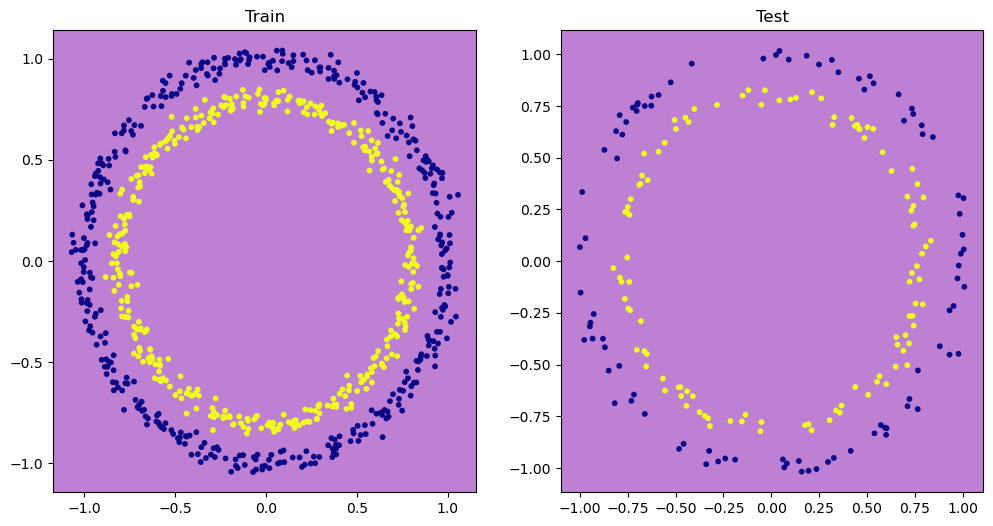

In [36]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

The linear model seems to be not learning anything, even after imporvements, it seems to be just guessing 0 all the time, so the following code will check if this model can even learn anything using some sample linear data

In [37]:
weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.002

X_linear = torch.arange(start, end, step).unsqueeze(dim=1)
y_linear = weight * X_linear + bias

print(len(X_linear))
X_linear[:5], y_linear[:5]

500


(tensor([[0.0000],
         [0.0020],
         [0.0040],
         [0.0060],
         [0.0080]]),
 tensor([[0.3000],
         [0.3014],
         [0.3028],
         [0.3042],
         [0.3056]]))

In [38]:
train_split = int(0.8 * len(X_linear))

X_train_linear, y_train_linear = X_linear[:train_split], y_linear[:train_split]
X_test_linear, y_test_linear = X_linear[train_split:], y_linear[train_split:]

len(X_train_linear), len(y_train_linear), len(X_test_linear), len(y_test_linear)

(400, 400, 100, 100)

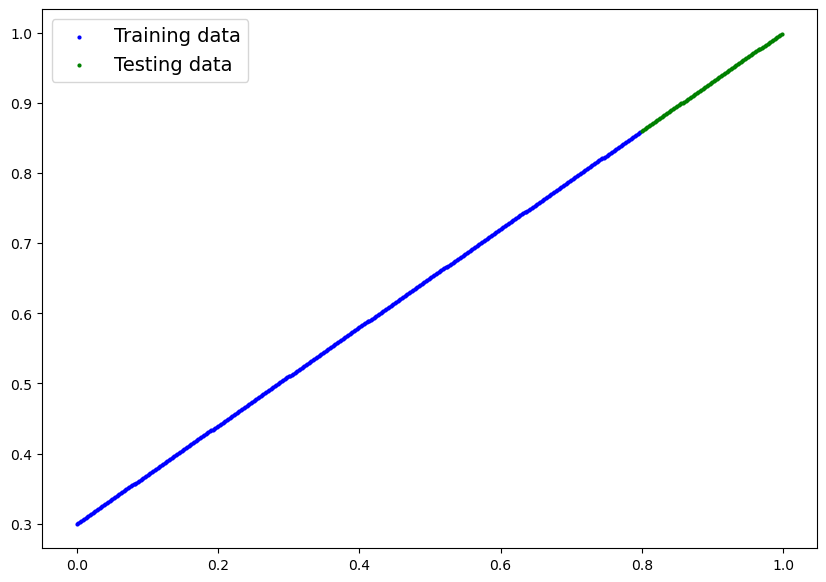

In [39]:
plot_predictions(train_data=X_train_linear, train_labels=y_train_linear, test_data=X_test_linear, test_labels=y_test_linear)

In [40]:
torch.manual_seed(42)
torch.mps.manual_seed(42)

model_2 = nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1)
).to(device)

In [41]:
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params=model_2.parameters(), lr=0.1)

In [42]:
torch.manual_seed(42)
torch.mps.manual_seed(42)

epochs = 1000

X_train_linear, y_train_linear = X_train_linear.to(device), y_train_linear.to(device)
X_test_linear, y_test_linear = X_test_linear.to(device), y_test_linear.to(device)

for epoch in range(epochs):

    model_2.train()

    y_pred = model_2(X_train_linear)

    loss = loss_fn(y_pred, y_train_linear)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model_2.eval()

    with torch.inference_mode():
        test_pred = model_2(X_test_linear)
        test_loss = loss_fn(test_pred, y_test_linear)

    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:5f} | Test Loss: {test_loss:5f}")
    

Epoch: 0 | Loss: 0.761411 | Test Loss: 0.541414


/opt/homebrew/anaconda3/envs/ml/lib/python3.11/site-packages/torch/autograd/__init__.py:200: UserWarning: The operator 'aten::sgn.out' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_1aidzjezue/croot/pytorch_1687856425340/work/aten/src/ATen/mps/MPSFallback.mm:11.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch: 100 | Loss: 0.092084 | Test Loss: 0.027201
Epoch: 200 | Loss: 0.072852 | Test Loss: 0.012187
Epoch: 300 | Loss: 0.062514 | Test Loss: 0.009501
Epoch: 400 | Loss: 0.065105 | Test Loss: 0.021198
Epoch: 500 | Loss: 0.070266 | Test Loss: 0.023644
Epoch: 600 | Loss: 0.062603 | Test Loss: 0.024975
Epoch: 700 | Loss: 0.070472 | Test Loss: 0.017559
Epoch: 800 | Loss: 0.058114 | Test Loss: 0.016597
Epoch: 900 | Loss: 0.060484 | Test Loss: 0.023376


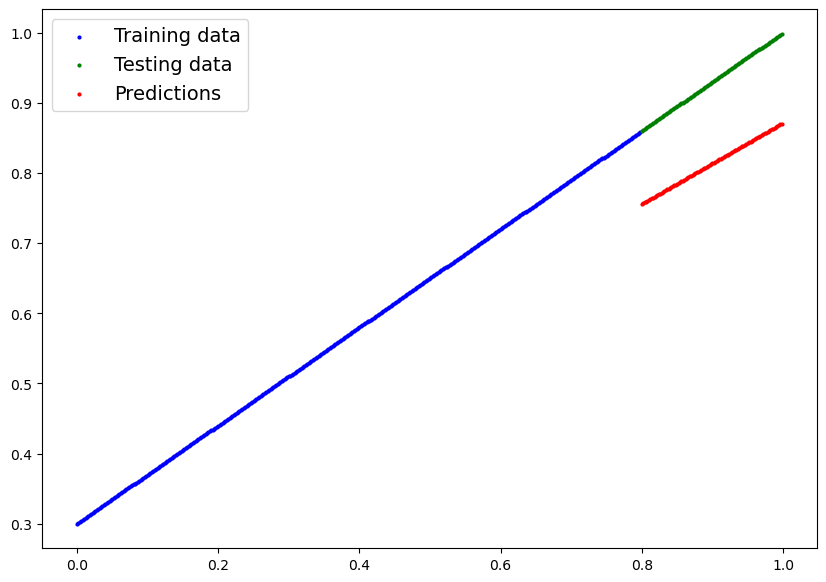

In [43]:
model_2.eval()

with torch.inference_mode():
    y_preds = model_2(X_test_linear)

plot_predictions(train_data=X_train_linear.cpu(), train_labels=y_train_linear.cpu(), test_data=X_test_linear.cpu(), test_labels=y_test_linear.cpu(), predictions=y_preds.cpu())

## 6. Non-Linearity

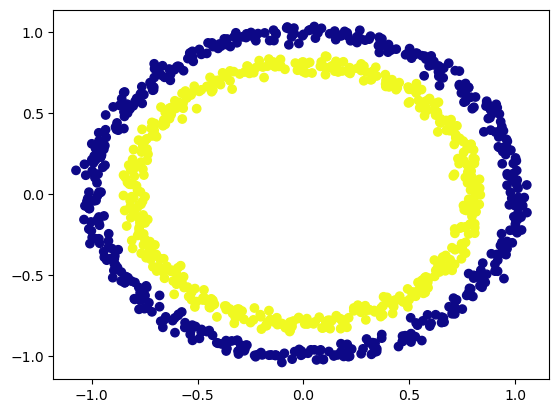

In [44]:
n_samples = 1000

X, y = make_circles(n_samples, noise=0.03, random_state=123)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap="plasma");

In [45]:
X = torch.from_numpy(X).type(torch.float32)
y = torch.from_numpy(y).type(torch.float32)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

In [46]:
X_train[:5], y_train[:5]

(tensor([[ 0.7149, -0.7400],
         [ 0.0748, -0.7606],
         [ 0.1461, -0.9945],
         [-0.7351, -0.1578],
         [ 0.9209,  0.2904]]),
 tensor([0., 1., 0., 1., 0.]))

In [47]:
class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(in_features=2, out_features=10)
        self.layer2 = nn.Linear(in_features=10, out_features=10)
        self.layer3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        return self.layer3(self.relu(self.layer2(self.relu(self.layer1(x)))))

In [48]:
torch.manual_seed(123)
torch.mps.manual_seed(123)

model_3 = CircleModelV2().to(device)
model_3

CircleModelV2(
  (layer1): Linear(in_features=2, out_features=10, bias=True)
  (layer2): Linear(in_features=10, out_features=10, bias=True)
  (layer3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [49]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_3.parameters(), lr=0.1)

In [50]:
torch.manual_seed(123)
torch.mps.manual_seed(123)

epochs = 2000

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    model_3.train()
    
    y_logits = model_3(X_train).squeeze()
    y_preds = torch.round(torch.sigmoid(y_logits))
    
    loss = loss_fn(y_logits, y_train)
    acc = get_accuracy(y_train, y_preds)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    model_3.eval()
    with torch.inference_mode():
        test_logits = model_3(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        
        test_loss = loss_fn(test_logits, y_test)
        test_acc = get_accuracy(y_test, test_pred)
    
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:5f} | Acc: {acc:2f}% | Test Loss: {test_loss:5f} | Test Acc: {test_acc:2f}%")

Epoch: 0 | Loss: 0.715773 | Acc: 48.875000% | Test Loss: 0.691195 | Test Acc: 54.500000%
Epoch: 100 | Loss: 0.689732 | Acc: 54.250000% | Test Loss: 0.690089 | Test Acc: 53.500000%
Epoch: 200 | Loss: 0.688177 | Acc: 55.125000% | Test Loss: 0.689001 | Test Acc: 53.500000%
Epoch: 300 | Loss: 0.686331 | Acc: 54.500000% | Test Loss: 0.687690 | Test Acc: 54.000000%
Epoch: 400 | Loss: 0.683864 | Acc: 54.500000% | Test Loss: 0.686006 | Test Acc: 54.000000%
Epoch: 500 | Loss: 0.680483 | Acc: 55.000000% | Test Loss: 0.683658 | Test Acc: 56.000000%
Epoch: 600 | Loss: 0.675577 | Acc: 58.000000% | Test Loss: 0.680272 | Test Acc: 56.500000%
Epoch: 700 | Loss: 0.668200 | Acc: 64.500000% | Test Loss: 0.674670 | Test Acc: 62.500000%
Epoch: 800 | Loss: 0.656475 | Acc: 70.625000% | Test Loss: 0.664941 | Test Acc: 69.000000%
Epoch: 900 | Loss: 0.636759 | Acc: 80.750000% | Test Loss: 0.646864 | Test Acc: 75.500000%
Epoch: 1000 | Loss: 0.597803 | Acc: 86.375000% | Test Loss: 0.605577 | Test Acc: 83.500000%


In [51]:
model_3.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()

y_preds[:10], y_test[:10]

(tensor([0., 1., 0., 1., 1., 0., 0., 1., 1., 0.], device='mps:0'),
 tensor([0., 1., 0., 1., 1., 0., 0., 1., 1., 0.], device='mps:0'))

[0. 1.]
[0. 1.]


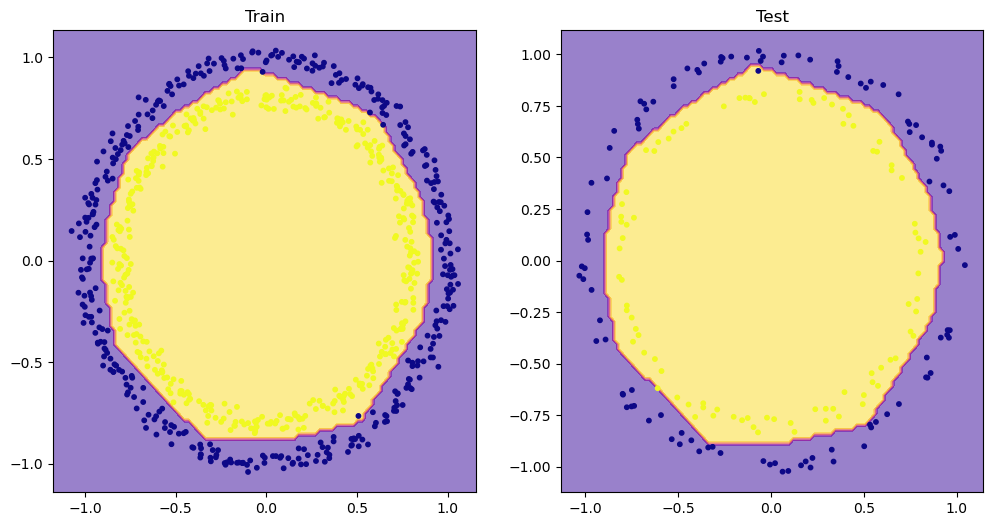

In [52]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_3, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test)

## 7. Replecating Non-Linear Activation Functions

In [53]:
A = torch.arange(-10, 10, 1, dtype=torch.float32)

In [54]:
A

tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
          2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.])

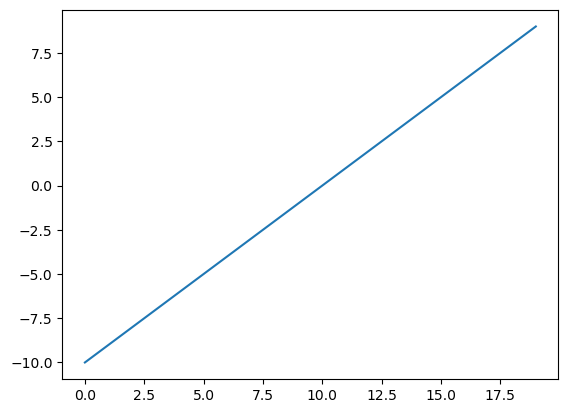

In [55]:
plt.plot(A);

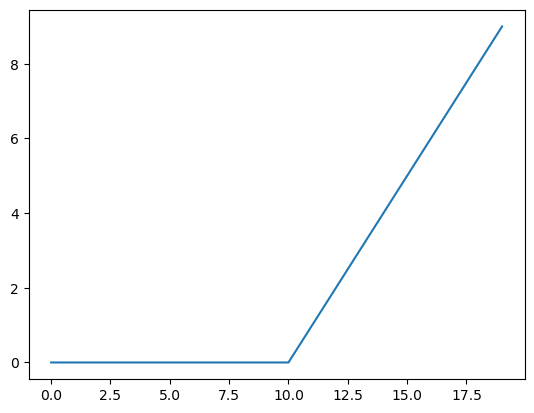

In [56]:
plt.plot(torch.relu(A));

In [57]:
def relu(x: torch.Tensor) -> torch.Tensor:
    return torch.maximum(torch.tensor(0), x)

relu(A)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8., 9.])

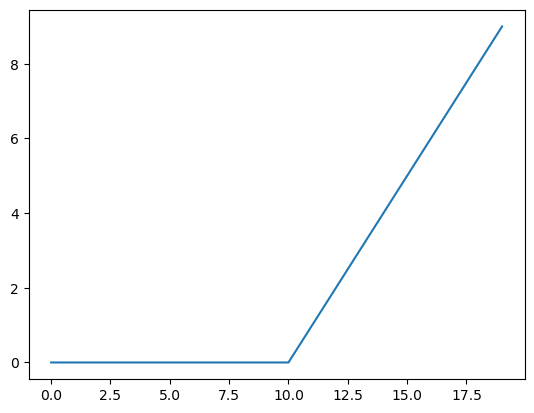

In [58]:
plt.plot(relu(A))

In [59]:
def sigmoid(x: torch.Tensor) -> torch.Tensor:
    return 1/(1+torch.exp(-x))

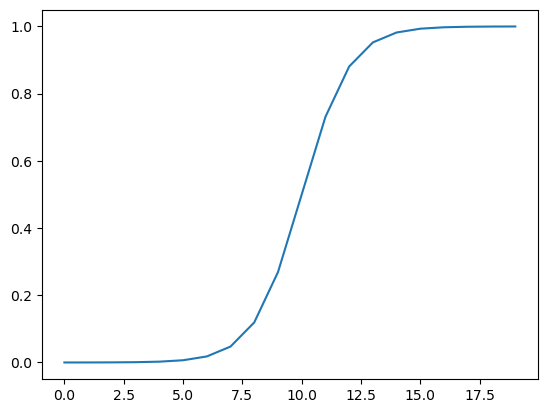

In [60]:
plt.plot(torch.sigmoid(A));

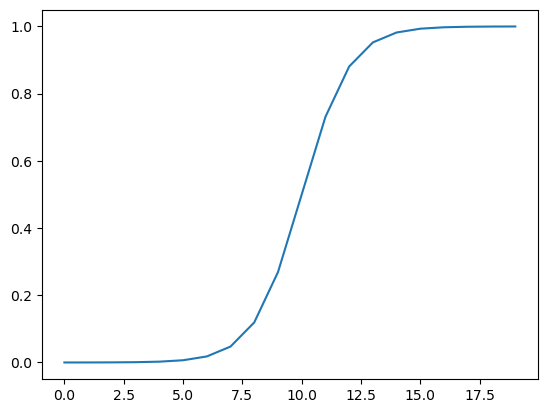

In [61]:
plt.plot(sigmoid(A));

## 8. Multi-class Classification Problem

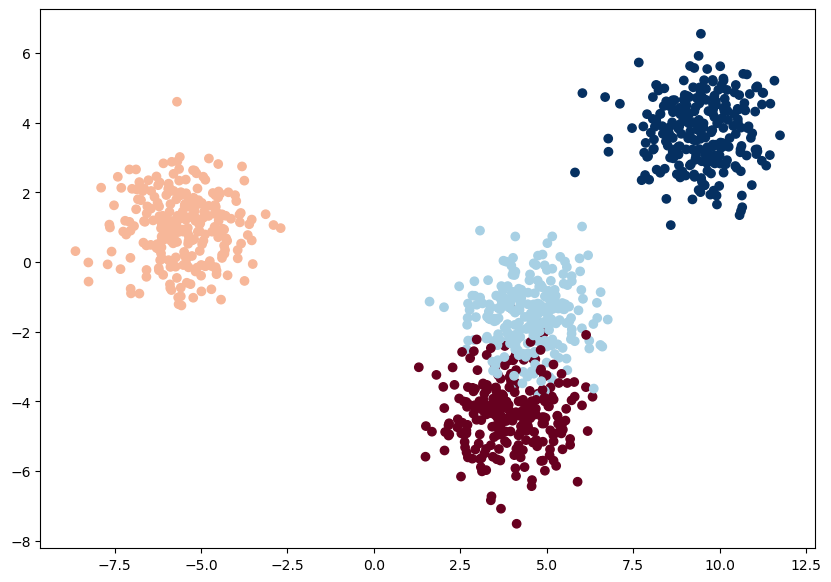

In [99]:
from sklearn.datasets import make_blobs

NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 123

X, y = make_blobs(n_samples=1000, n_features=NUM_FEATURES, centers=NUM_CLASSES, cluster_std=1, random_state=RANDOM_SEED)

X = torch.from_numpy(X).type(torch.float32)
y = torch.from_numpy(y).type(torch.long)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

plt.figure(figsize=(10,7))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="RdBu");

In [102]:
class BlobModelV1(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=output_features)
        )
    def forward(self, x):
        return self.linear_layer_stack(x)

In [103]:
model_4 = BlobModelV1(input_features=2, output_features=4).to(device)
model_4

BlobModelV1(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [104]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_4.parameters(), lr=0.1)

In [105]:
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X_test.to("mps"))

y_logits[:5]

tensor([[-0.1522, -0.5086,  0.6646, -0.2585],
        [ 0.3458,  0.5490,  0.2324, -0.8029],
        [ 0.0059,  0.0036, -0.1273,  0.3882],
        [ 0.0204,  0.1369, -0.5197,  0.8478],
        [ 0.1341,  0.7221, -1.8929,  2.3191]], device='mps:0')

In [106]:
y_pred_probs = torch.softmax(y_logits, dim=1)
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[-0.1522, -0.5086,  0.6646, -0.2585],
        [ 0.3458,  0.5490,  0.2324, -0.8029],
        [ 0.0059,  0.0036, -0.1273,  0.3882],
        [ 0.0204,  0.1369, -0.5197,  0.8478],
        [ 0.1341,  0.7221, -1.8929,  2.3191]], device='mps:0')
tensor([[0.2057, 0.1440, 0.4654, 0.1849],
        [0.2911, 0.3567, 0.2599, 0.0923],
        [0.2305, 0.2300, 0.2017, 0.3378],
        [0.2003, 0.2250, 0.1167, 0.4581],
        [0.0846, 0.1523, 0.0111, 0.7520]], device='mps:0')


In [107]:
torch.sum(y_pred_probs[0])

tensor(1., device='mps:0')

In [108]:
y_preds = torch.argmax(y_pred_probs, dim=1)
y_preds = y_preds.type(torch.float32)
y_preds, y_test

(tensor([2., 1., 3., 3., 3., 3., 2., 3., 2., 1., 2., 3., 3., 3., 3., 2., 3., 1.,
         1., 2., 3., 3., 1., 1., 2., 1., 3., 3., 3., 3., 2., 1., 3., 1., 2., 3.,
         3., 3., 3., 3., 3., 2., 3., 3., 3., 2., 3., 2., 2., 2., 1., 3., 3., 3.,
         3., 3., 3., 2., 3., 2., 2., 2., 3., 2., 1., 3., 3., 2., 2., 3., 3., 1.,
         3., 1., 3., 1., 3., 2., 1., 1., 2., 3., 1., 3., 1., 2., 3., 3., 3., 2.,
         1., 3., 3., 3., 2., 2., 1., 3., 3., 1., 2., 1., 1., 3., 3., 3., 2., 3.,
         1., 2., 2., 2., 1., 3., 1., 2., 3., 1., 2., 2., 3., 2., 3., 2., 3., 3.,
         2., 3., 3., 2., 3., 3., 2., 2., 1., 2., 2., 1., 3., 3., 3., 1., 1., 2.,
         2., 3., 3., 3., 3., 3., 3., 3., 3., 2., 2., 1., 3., 1., 3., 2., 3., 2.,
         2., 1., 3., 2., 3., 3., 2., 3., 3., 3., 1., 2., 3., 2., 1., 3., 3., 1.,
         3., 1., 3., 2., 2., 1., 3., 3., 3., 1., 3., 3., 3., 2., 2., 2., 2., 1.,
         2., 2.], device='mps:0'),
 tensor([0, 1, 0, 2, 3, 2, 0, 3, 0, 1, 0, 2, 2, 2, 3, 0, 3, 1, 1, 1, 2, 3,

In [109]:
torch.manual_seed(123)
torch.mps.manual_seed(123)

epochs = 100

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    
    model_4.train()
    
    y_logits = model_4(X_train)
    y_preds = torch.softmax(y_logits, dim=1).argmax(dim=1)
    
    loss = loss_fn(y_logits, y_train)
    acc = get_accuracy(y_train, y_preds)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    model_4.eval()
    
    with torch.inference_mode():
        
        test_logits = model_4(X_test)
        test_preds = torch.softmax(test_logits, dim=1).argmax(dim=1)
        
        test_loss = loss_fn(test_logits, y_test)
        test_acc = get_accuracy(y_test, test_preds)
        
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:5f} | Acc: {acc:2f}% | Test Loss: {test_loss:5f} | Test Acc: {test_acc:2f}%")

Epoch: 0 | Loss: 1.129549 | Acc: 45.500000% | Test Loss: 0.895032 | Test Acc: 49.500000%
Epoch: 10 | Loss: 0.337716 | Acc: 90.375000% | Test Loss: 0.363317 | Test Acc: 88.000000%
Epoch: 20 | Loss: 0.230054 | Acc: 94.750000% | Test Loss: 0.255121 | Test Acc: 92.000000%
Epoch: 30 | Loss: 0.178264 | Acc: 95.375000% | Test Loss: 0.204683 | Test Acc: 93.000000%
Epoch: 40 | Loss: 0.151289 | Acc: 95.375000% | Test Loss: 0.179315 | Test Acc: 93.500000%
Epoch: 50 | Loss: 0.135847 | Acc: 95.375000% | Test Loss: 0.165287 | Test Acc: 93.500000%
Epoch: 60 | Loss: 0.126224 | Acc: 95.250000% | Test Loss: 0.156880 | Test Acc: 93.500000%
Epoch: 70 | Loss: 0.119802 | Acc: 95.125000% | Test Loss: 0.151511 | Test Acc: 93.500000%
Epoch: 80 | Loss: 0.115272 | Acc: 95.250000% | Test Loss: 0.147899 | Test Acc: 93.500000%
Epoch: 90 | Loss: 0.111925 | Acc: 95.375000% | Test Loss: 0.145357 | Test Acc: 93.500000%


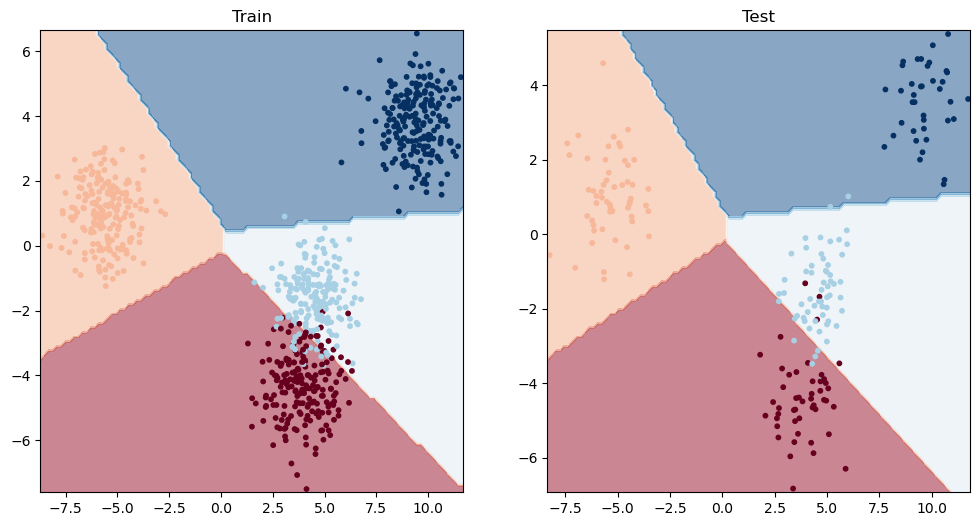

In [110]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_4, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_4, X_test, y_test)

## 9. More Evaluation Metrics For Classification Models

* Accuracy
* Precision
* Recall
* F-1 Score
* Confusion Matrix
* Classification Report